In [71]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from dython.nominal import associations
import seaborn as sns
from datetime import date
import calendar
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import detectEnglish

df_calendar = pd.read_csv('./calendar.csv')
df_listings = pd.read_csv('./listings.csv')
df_reviews = pd.read_csv('./reviews.csv')


In [ ]:
Print("Test Git Hub for new PC")

In [2]:
print("Calendar datatset has {} rows and {} columns".format(df_calendar.shape[0],df_calendar.shape[1]))
print("Listings datatset has {} rows and {} columns".format(df_listings.shape[0],df_listings.shape[1]))
print("Reviews datatset has {} rows and {} columns".format(df_reviews.shape[0],df_reviews.shape[1]))

Calendar datatset has 1393570 rows and 4 columns
Listings datatset has 3818 rows and 92 columns
Reviews datatset has 84849 rows and 6 columns


In [3]:
#create function to find out the columns with missing values
def identify_null_col(dataframe):
    """Identify columns that have missing data in the dataframe
    
    Input:
        dataframe: input dataframe to identify missing data
        
    Returns:
        dataframe: dataframe of column names as index, # missing records, % missing records
    """
    
    null_col = dataframe.columns[dataframe.isna().sum()>0]
    col_null_val = dataframe[null_col].isna().sum().sort_values(ascending=False)
    per_null_val = (dataframe[null_col].isna().sum()/dataframe.shape[0]*100).sort_values(ascending=False)
    nulls_df = pd.DataFrame(col_null_val,columns=['#Nulls'])
    nulls_df['%Nulls']=per_null_val
    print('Number of columns with missing data:',nulls_df.shape[0])
    return nulls_df

# To answer following questions from the datasets:

(a) From Visitor view:
1. How does the price of Airbnb  fluctuate across a year in Seattle?
2. *How are the available listing and rent price distributed by location in Seattle?
3. *Will the experience of Seattle Airbnb renters vary by time?

(b) From Airbnb providers view:
1. When is the peak and off-peak season?
2. *What can hosts do to improve their review rating?
3. *For “newbies” considering becoming  Airbnb hosts in Seattle, how competitive are they in this market compared to experienced hosts? 

Medium post only cover questions with *

# Part I: Clean dataset

Clean calendar datase

In [4]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
df_calendar['available'].value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [6]:
#converting price column into numeric variable
df_calendar['price'] = df_calendar['price'].str.replace("$","")
df_calendar['price'] = df_calendar['price'].str.replace("'","")
df_calendar['price'] = df_calendar['price'].str.replace(",","")
df_calendar['price'] = df_calendar['price'].astype('float')
#converting the date column into datetime
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

In [7]:
#creating a column for day of week
df_calendar['day of week'] = df_calendar['date'].dt.day_name()
#creating a column for month of year
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar['month'] = df_calendar['month'].apply(lambda x: calendar.month_abbr[x])
#creating a column for quarter of year
df_calendar['quarter'] = pd.PeriodIndex(df_calendar.date, freq='Q')
df_calendar.head()

,listing_id,date,available,price,day of week,month,quarter
0,241032,2016-01-04,t,85.0,Monday,Jan,2016Q1
1,241032,2016-01-05,t,85.0,Tuesday,Jan,2016Q1
2,241032,2016-01-06,f,NaN,Wednesday,Jan,2016Q1
3,241032,2016-01-07,f,NaN,Thursday,Jan,2016Q1
4,241032,2016-01-08,f,NaN,Friday,Jan,2016Q1


Clean listing data

In [8]:
#understand the data in df_listings
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [9]:
#identify columns with missing value in df_listings dataset
identify_null_col(df_listings)

Number of columns with missing data: 45


,#Nulls,%Nulls
license,3818,100.000000
square_feet,3721,97.459403
monthly_price,2301,60.267156
security_deposit,1952,51.126244
weekly_price,1809,47.380828
notes,1606,42.063908
neighborhood_overview,1032,27.029859
cleaning_fee,1030,26.977475
transit,934,24.463070
host_about,859,22.498690


In [10]:
#clean the 'price' column in df_listings
df_listings['price'] = df_listings['price'].str.replace("$","")
df_listings['price']  = df_listings['price'].str.replace("'","")
df_listings['price'] = df_listings['price'].str.replace(",","")
df_listings['price'] = df_listings['price'].astype('float')

# Part II: From the perspective of visitors

# (a) 1. How does the price of Airbnb fluctuate across a year in Seattle?

In [11]:
#evaluating the average price of each day of week
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_weekday = df_calendar.groupby(['day of week']).mean()[['price']].reindex(cats)
group_weekday = group_weekday.reset_index()

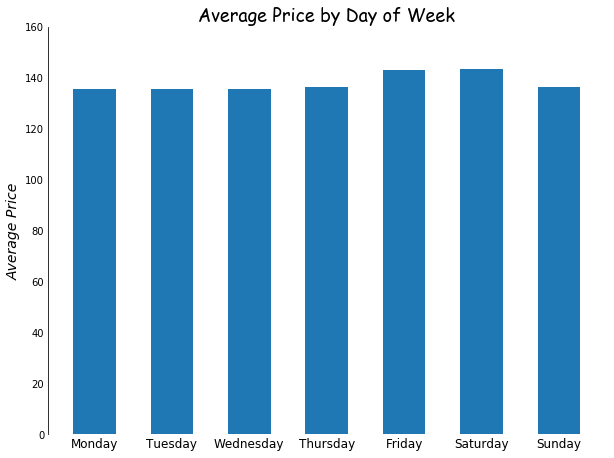

In [12]:
#create x and y for plotting figure of average price by day of week
xdata = group_weekday['day of week']
ydata = group_weekday['price']
#plot the graph
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
l = ax.bar(xdata, ydata, width=0.55)
#set the basic properties
ax.set_xlabel('')
ax.set_ylabel('Average Price')
ax.set_title('Average Price by Day of Week',fontname="Comic Sans MS")
#set the limits
ax.set_ylim(0, 160)
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)

plt.savefig('Average Price by Day of Week.png')

In [13]:
#evaluating the average price of each month
mons = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
group_month = df_calendar.groupby(['month']).mean()[['price']].reindex(mons)
group_month = group_month.reset_index()

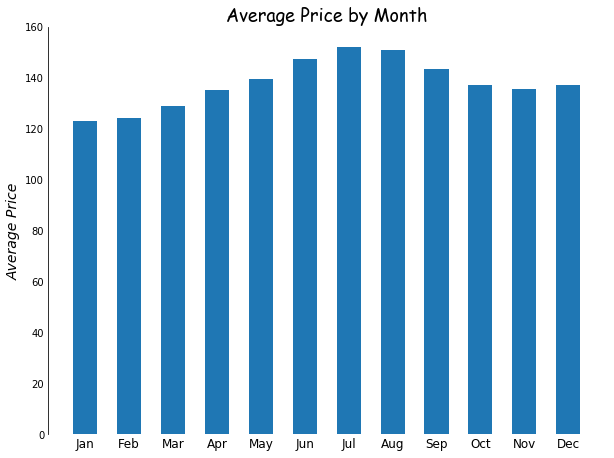

In [14]:
#create x and y for plotting figure of average price of each month
xdata = group_month['month']
ydata = group_month['price']
#plot the graph
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
l = ax.bar(xdata, ydata, width=0.55)
#set the basic properties
ax.set_xlabel('')
ax.set_ylabel('Average Price')
ax.set_title('Average Price by Month',fontname="Comic Sans MS")
#set the limits
ax.set_ylim(0, 160)
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)

plt.savefig('Average Price by Month.png')

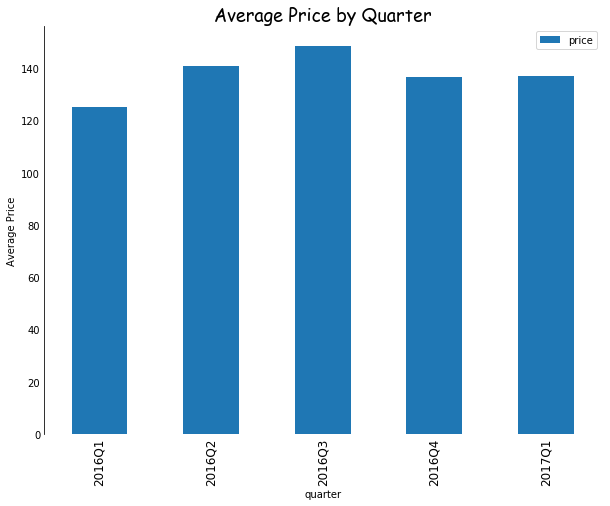

In [15]:
#evaluating the average price of each quarter
group_quarter = df_calendar.groupby(['quarter']).mean()[['price']]
#create figure of average price by quarter
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
ax.set_title('Average Price by Quarter',fontname="Comic Sans MS")
ax.set_xlabel('')
ax.set_ylabel('Average Price')
ttl = ax.title
ttl.set_size(18)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
group_quarter.plot.bar(ax=ax)

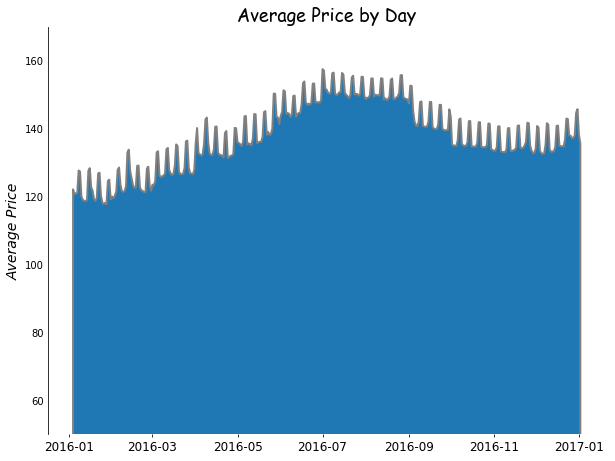

In [16]:
#evaluating the average price of each day
group_day = df_calendar.groupby(['date']).mean()[['price']]
group_day = group_day.reset_index()

#create x and y for plotting figure of average price of each month
xdata = group_day['date']
ydata = group_day['price']
#plot the graph
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
l = ax.fill_between(xdata, ydata, color = "tab:blue")
#set the basic properties
ax.set_xlabel('')
ax.set_ylabel('Average Price')
ax.set_title('Average Price by Day',fontname="Comic Sans MS")
#set the limits
ax.set_ylim(50, 170)
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=3,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)
# change the edge color (bluish and transparentish) and thickness
l.set_edgecolors("grey")
l.set_linewidths([2])

plt.savefig('Average Price by Day.png')

Conclusion: The price goes up since January, reaching its peak around the summer time, eg. June, July, and August. Then it starts to falling until Decemeber. Within a week, the Airbnb price of Friday and Saturday are relatively higher, the rest of week stay at similar lower level.

# (a) 2. * How are the available listing and rent price distributed by location in Seattle?

In [17]:
#Understand the overall location of Airbnb in Seattle
df_listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

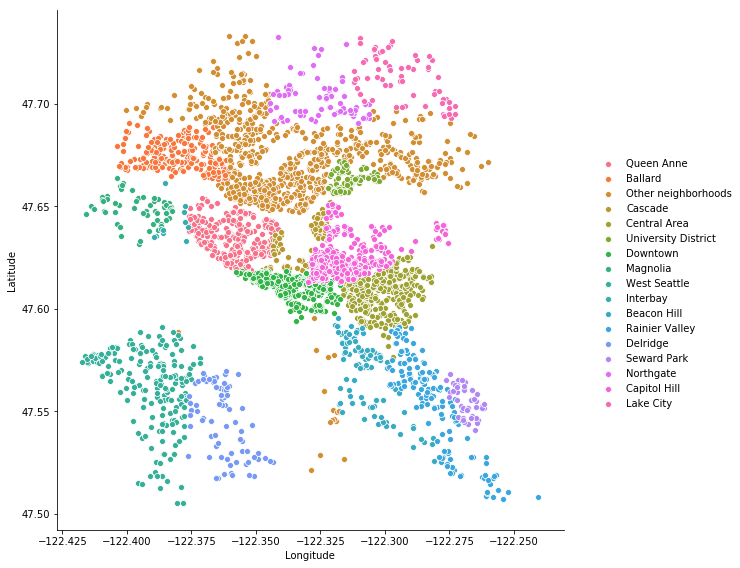

In [18]:
#visualize the geographic distribution of listings
ax = sns.pairplot(x_vars=["longitude"], y_vars=["latitude"], data=df_listings, hue="neighbourhood_group_cleansed",height=8)
ax._legend.set_title([])
ax.set(xlabel = 'Longitude',ylabel = 'Latitude')
ax.savefig('price_location.png')

The result can also be found through visualization created by Tableau https://public.tableau.com/profile/zhili.wen#!/vizhome/AirBnBAvailabilityinSeattle/Dashboard1?publish=yes.

In [19]:
#Just see the option is not enough, let see the avaiable rate accross each area.

In [20]:
#merge the calendar dataset with listing datatset to df_booking, which contain region information and listing avaiability in each region
df_booking = pd.merge(df_calendar, df_listings[['id','neighbourhood_group_cleansed']], left_on = 'listing_id',right_on = 'id')

In [21]:
#convert the available column into 0 and 1
df_booking['available'] = (df_booking['available'] == 't').astype(int)

In [22]:
#evaluate the available rate by region
df_booking.groupby('neighbourhood_group_cleansed').mean().sort_values('available', ascending = False)['available']

neighbourhood_group_cleansed
Interbay               0.845330
Magnolia               0.774669
Lake City              0.768800
Delridge               0.747182
University District    0.744397
Northgate              0.722774
Beacon Hill            0.702809
West Seattle           0.701127
Ballard                0.692257
Seward Park            0.680012
Central Area           0.672354
Other neighborhoods    0.671685
Rainier Valley         0.670526
Downtown               0.649910
Capitol Hill           0.641048
Queen Anne             0.620423
Cascade                0.576174
Name: available, dtype: float64

In [23]:
#calculate the average price per bed
df_listings['price_perbed'] = df_listings['price']/df_listings['beds']

In [24]:
#evaluate the average price per bed by region
df_listings.groupby('neighbourhood_group_cleansed').mean().sort_values('price_perbed', ascending = False)[['price_perbed']]

,price_perbed
neighbourhood_group_cleansed,
Downtown,103.301539
Interbay,102.909091
Cascade,102.086142
Queen Anne,96.848878
Capitol Hill,91.282321
Magnolia,89.441335
West Seattle,78.830167
Central Area,77.767397
Ballard,73.265704


Conclusion: If you are travelling to Seattle, the majority of Airbnb options are located in central and northern Seattle. Northern Seattle has the best balance—being price friendly and having many stay options to choose from. 

# (a) 3. * Will the experience of Seattle Airbnb renters vary by time?

In [72]:
#create review dataframe without missing value on guest comment column
reviews = pd.read_csv('./reviews.csv')
reviews = reviews.dropna(subset =['comments'],how='any')

#to detect non-English comments, I use a helper function called detectEnglish 
## provided by http://inventwithpython.com/hacking (BSD Licensed)
reviews['Eng'] = reviews['comments'].apply(lambda row: detectEnglish.isEnglish(row))
#drop non-english comments
reviews = reviews[reviews['Eng']==True]

#identify and drop automatically comment from system
reviews['auto'] = reviews['comments'].apply(lambda row: "This is an automated posting" in row)
reviews = reviews[reviews['auto']==False]
print('Number of reviews after cleaning:', reviews.shape[0])

Number of reviews after cleaning: 83195


In [73]:
#Analyze the sentiment of each comment
analyzer = SentimentIntensityAnalyzer()                                                 
reviews['polarity_Vader']= reviews['comments'].apply(lambda row:analyzer.polarity_scores(row)['compound'])
reviews['sentiment_Vader'] = np.where(reviews['polarity_Vader']>= 0.05, 1, \
                                       (np.where(reviews['polarity_Vader']<=-0.05, -1, 0)))

In [74]:
reviews['sentiment_Vader'].value_counts()

 1    82320
-1      516
 0      359
Name: sentiment_Vader, dtype: int64

In [75]:
#convert date to datetime in review dataframe
reviews['date'] = pd.to_datetime(reviews['date'])
#create month column
reviews['month'] = reviews['date'].dt.month
reviews['month'] = reviews['month'].apply(lambda x: calendar.month_abbr[x])
#create dataframe review_negative for only 'bad' review
review_negative = reviews[reviews['sentiment_Vader']<=0]

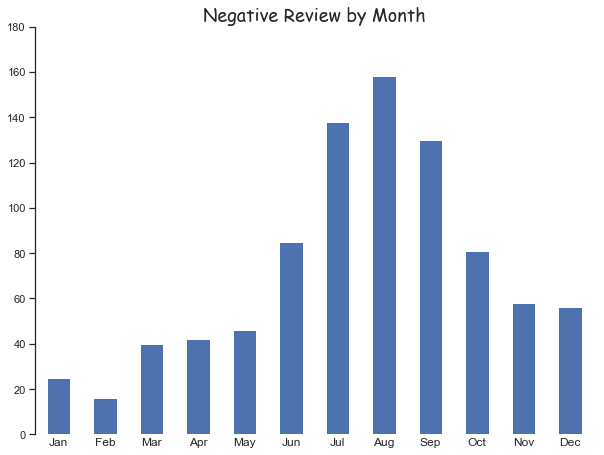

In [76]:
#evaluate the negative review distribution by month
mons = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
negative_month = review_negative['listing_id'].groupby(review_negative['month']).count().reindex(mons)
plt.figure(figsize=(10, 7.5))
#basic setting for the plot
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.set_title("Negative Review by Month", fontname="Comic Sans MS")
ax.xaxis.set_tick_params(size=0,labelsize=12)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)
ax = negative_month.plot.bar()
ax.set_ylim(0, 180)
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(rotation='horizontal')
fig = ax.get_figure()
fig.savefig('Negative Review by Month.png', bbox_inches='tight')

<Figure size 1080x504 with 0 Axes>

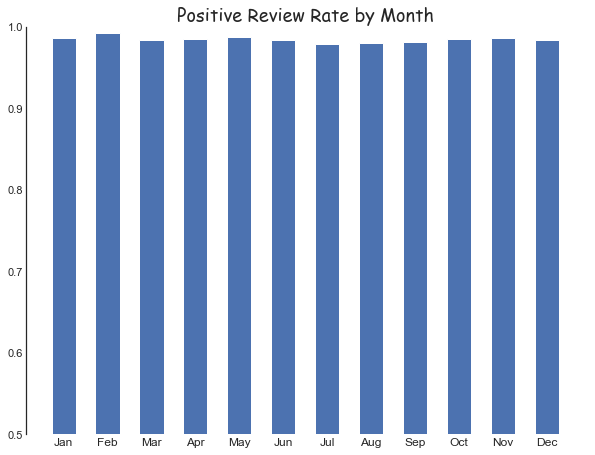

In [77]:
#evaluate the relationship between positive review rate by month
plt.figure(figsize=(15,7))
mons = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
positive_rate_month_3 = reviews.groupby(['month']).mean()[['sentiment_Vader']].reindex(mons)
positive_rate_month_3 = positive_rate_month_3.reset_index()
#create x and y for plotting figure of booking per month by host join year
xdata = positive_rate_month_3['month']
ydata = positive_rate_month_3['sentiment_Vader']
#plot the graph
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
l = ax.bar(xdata, ydata, width=0.55)
#set the basic properties
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Positive Review Rate by Month',fontname="Comic Sans MS")
#set the limits
ax.set_ylim(0.5, 1)
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)

plt.savefig('Positive Review Rate by Month', bbox_inches='tight')

Conclusion: Based on the result of (b)1, Seattle airbnb booking reached its peak during the summer time, from July to August. At same time, visitors made most amount of complaint (negative review) during the same time. But from the ratio of negative review among (indicated by positive review rate), the experience of guest should not vary by time in a year.

# Part III: From the perspective of visitors

# (b) 1. When is the peak and off-peak season? 

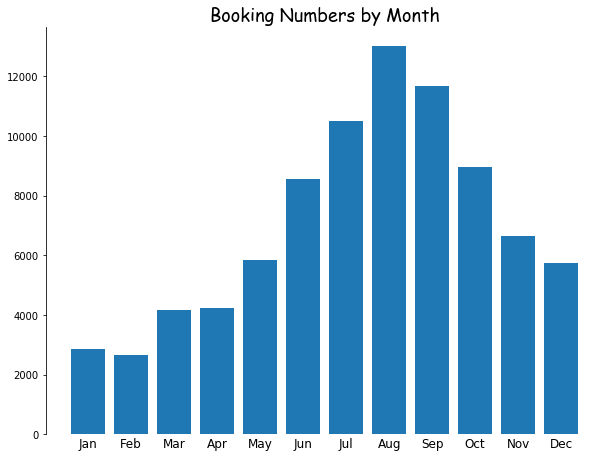

In [30]:
#converting the date column to datetime type
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
#creat month column in df_reviews dataframe
df_reviews['month'] = df_reviews['date'].dt.month
df_reviews['month'] = df_reviews['month'].apply(lambda x: calendar.month_abbr[x])
#plot # of bookings along with month
mons = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=(10, 7.5))
plotdata = df_reviews[['date']].groupby(df_reviews["month"]).count().reindex(mons)
plotdata.rename(columns={'date':'Number of Bookings'}, inplace=True)
#basic setting for the plot
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.set_title("Booking Numbers by Month", fontname="Comic Sans MS")
ax.xaxis.set_tick_params(size=0,labelsize=12)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)
plt.bar(plotdata.index, plotdata['Number of Bookings'])

plt.savefig('Booking Numbers by Month_tight.png', bbox_inches='tight')

Conclusion: Summer time (July, August, and September are the peak traveling season) with highest booking number. As a contrast, From Jan to Mar are off-peak season, they are perfect timing to schedule some regular maintenance to get ready for the upcoming hot travel season.

# (b) 2. * What can hosts do to improve their review rating?

In [31]:
# Pick possible variables that correlate with review rating score
subset_col = ['neighbourhood_group_cleansed','zipcode','room_type','bed_type','bedrooms','bathrooms','beds','host_is_superhost'
          ,'accommodates', 'number_of_reviews',"price","property_type","extra_people","host_response_rate","host_response_time","cleaning_fee","cancellation_policy","review_scores_rating"]
subset = df_listings[subset_col]

In [32]:
# Evaluate columns with missing value
identify_null_col(subset)

Number of columns with missing data: 10


,#Nulls,%Nulls
cleaning_fee,1030,26.977475
review_scores_rating,647,16.946045
host_response_time,523,13.698271
host_response_rate,523,13.698271
bathrooms,16,0.419068
zipcode,7,0.183342
bedrooms,6,0.157150
host_is_superhost,2,0.052383
property_type,1,0.026192
beds,1,0.026192


In [33]:
subset.head()

,neighbourhood_group_cleansed,zipcode,room_type,bed_type,bedrooms,bathrooms,beds,host_is_superhost,accommodates,number_of_reviews,price,property_type,extra_people,host_response_rate,host_response_time,cleaning_fee,cancellation_policy,review_scores_rating
0,Queen Anne,98119,Entire home/apt,Real Bed,1.0,1.0,1.0,f,4,207,85.0,Apartment,$5.00,96%,within a few hours,NaN,moderate,95.0
1,Queen Anne,98119,Entire home/apt,Real Bed,1.0,1.0,1.0,t,4,43,150.0,Apartment,$0.00,98%,within an hour,$40.00,strict,96.0
2,Queen Anne,98119,Entire home/apt,Real Bed,5.0,4.5,7.0,f,11,20,975.0,House,$25.00,67%,within a few hours,$300.00,strict,97.0
3,Queen Anne,98119,Entire home/apt,Real Bed,0.0,1.0,2.0,f,3,0,100.0,Apartment,$0.00,NaN,NaN,NaN,flexible,NaN
4,Queen Anne,98119,Entire home/apt,Real Bed,3.0,2.0,3.0,f,6,38,450.0,House,$15.00,100%,within an hour,$125.00,strict,92.0


In [34]:
#clean the extra_people columns
subset['extra_people'] = subset['extra_people'].str.replace("$","")
subset['extra_people']  = subset['extra_people'].str.replace("'","")
subset['extra_people'] = subset['extra_people'].str.replace(",","")
subset['extra_people'] = subset['extra_people'].astype('float')
#clean the cleaning_fee columns
subset['cleaning_fee'] = subset['cleaning_fee'].str.replace("$","")
subset['cleaning_fee']  = subset['cleaning_fee'].str.replace("'","")
subset['cleaning_fee'] = subset['cleaning_fee'].str.replace(",","")
subset['cleaning_fee'] = subset['cleaning_fee'].astype('float')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [35]:
#Drop rating column with missing value
subset = subset.dropna(subset=['review_scores_rating'])
#Impute 0 to the missing of cleaning_price(assume missing value in cleaning_price means no cost)
subset['cleaning_fee'].fillna(0,inplace=True)
#Clening the data in host_response_rate
subset['host_response_rate'] = subset['host_response_rate'].str.replace("%","").astype('float')
#cleaning the data in zipcode
subset['zipcode'] = subset['zipcode'].replace('99\n98122','98122')
#convert host_is_superhost into numeric variable
subset['host_is_superhost'] = (subset['host_is_superhost'] == 't').astype('float')
#impute missing values using most_frequent values for categorical variables
catervariable=['host_response_rate','host_response_time','zipcode','bathrooms','bedrooms','host_is_superhost','beds','property_type']
subset[catervariable] = subset[catervariable].fillna(subset[catervariable].mode().iloc[0])

In [36]:
subset.head()

,neighbourhood_group_cleansed,zipcode,room_type,bed_type,bedrooms,bathrooms,beds,host_is_superhost,accommodates,number_of_reviews,price,property_type,extra_people,host_response_rate,host_response_time,cleaning_fee,cancellation_policy,review_scores_rating
0,Queen Anne,98119,Entire home/apt,Real Bed,1.0,1.0,1.0,0.0,4,207,85.0,Apartment,5.0,96.0,within a few hours,0.0,moderate,95.0
1,Queen Anne,98119,Entire home/apt,Real Bed,1.0,1.0,1.0,1.0,4,43,150.0,Apartment,0.0,98.0,within an hour,40.0,strict,96.0
2,Queen Anne,98119,Entire home/apt,Real Bed,5.0,4.5,7.0,0.0,11,20,975.0,House,25.0,67.0,within a few hours,300.0,strict,97.0
4,Queen Anne,98119,Entire home/apt,Real Bed,3.0,2.0,3.0,0.0,6,38,450.0,House,15.0,100.0,within an hour,125.0,strict,92.0
5,Queen Anne,98119,Private room,Real Bed,1.0,1.0,1.0,0.0,2,17,120.0,House,30.0,100.0,within an hour,40.0,strict,95.0


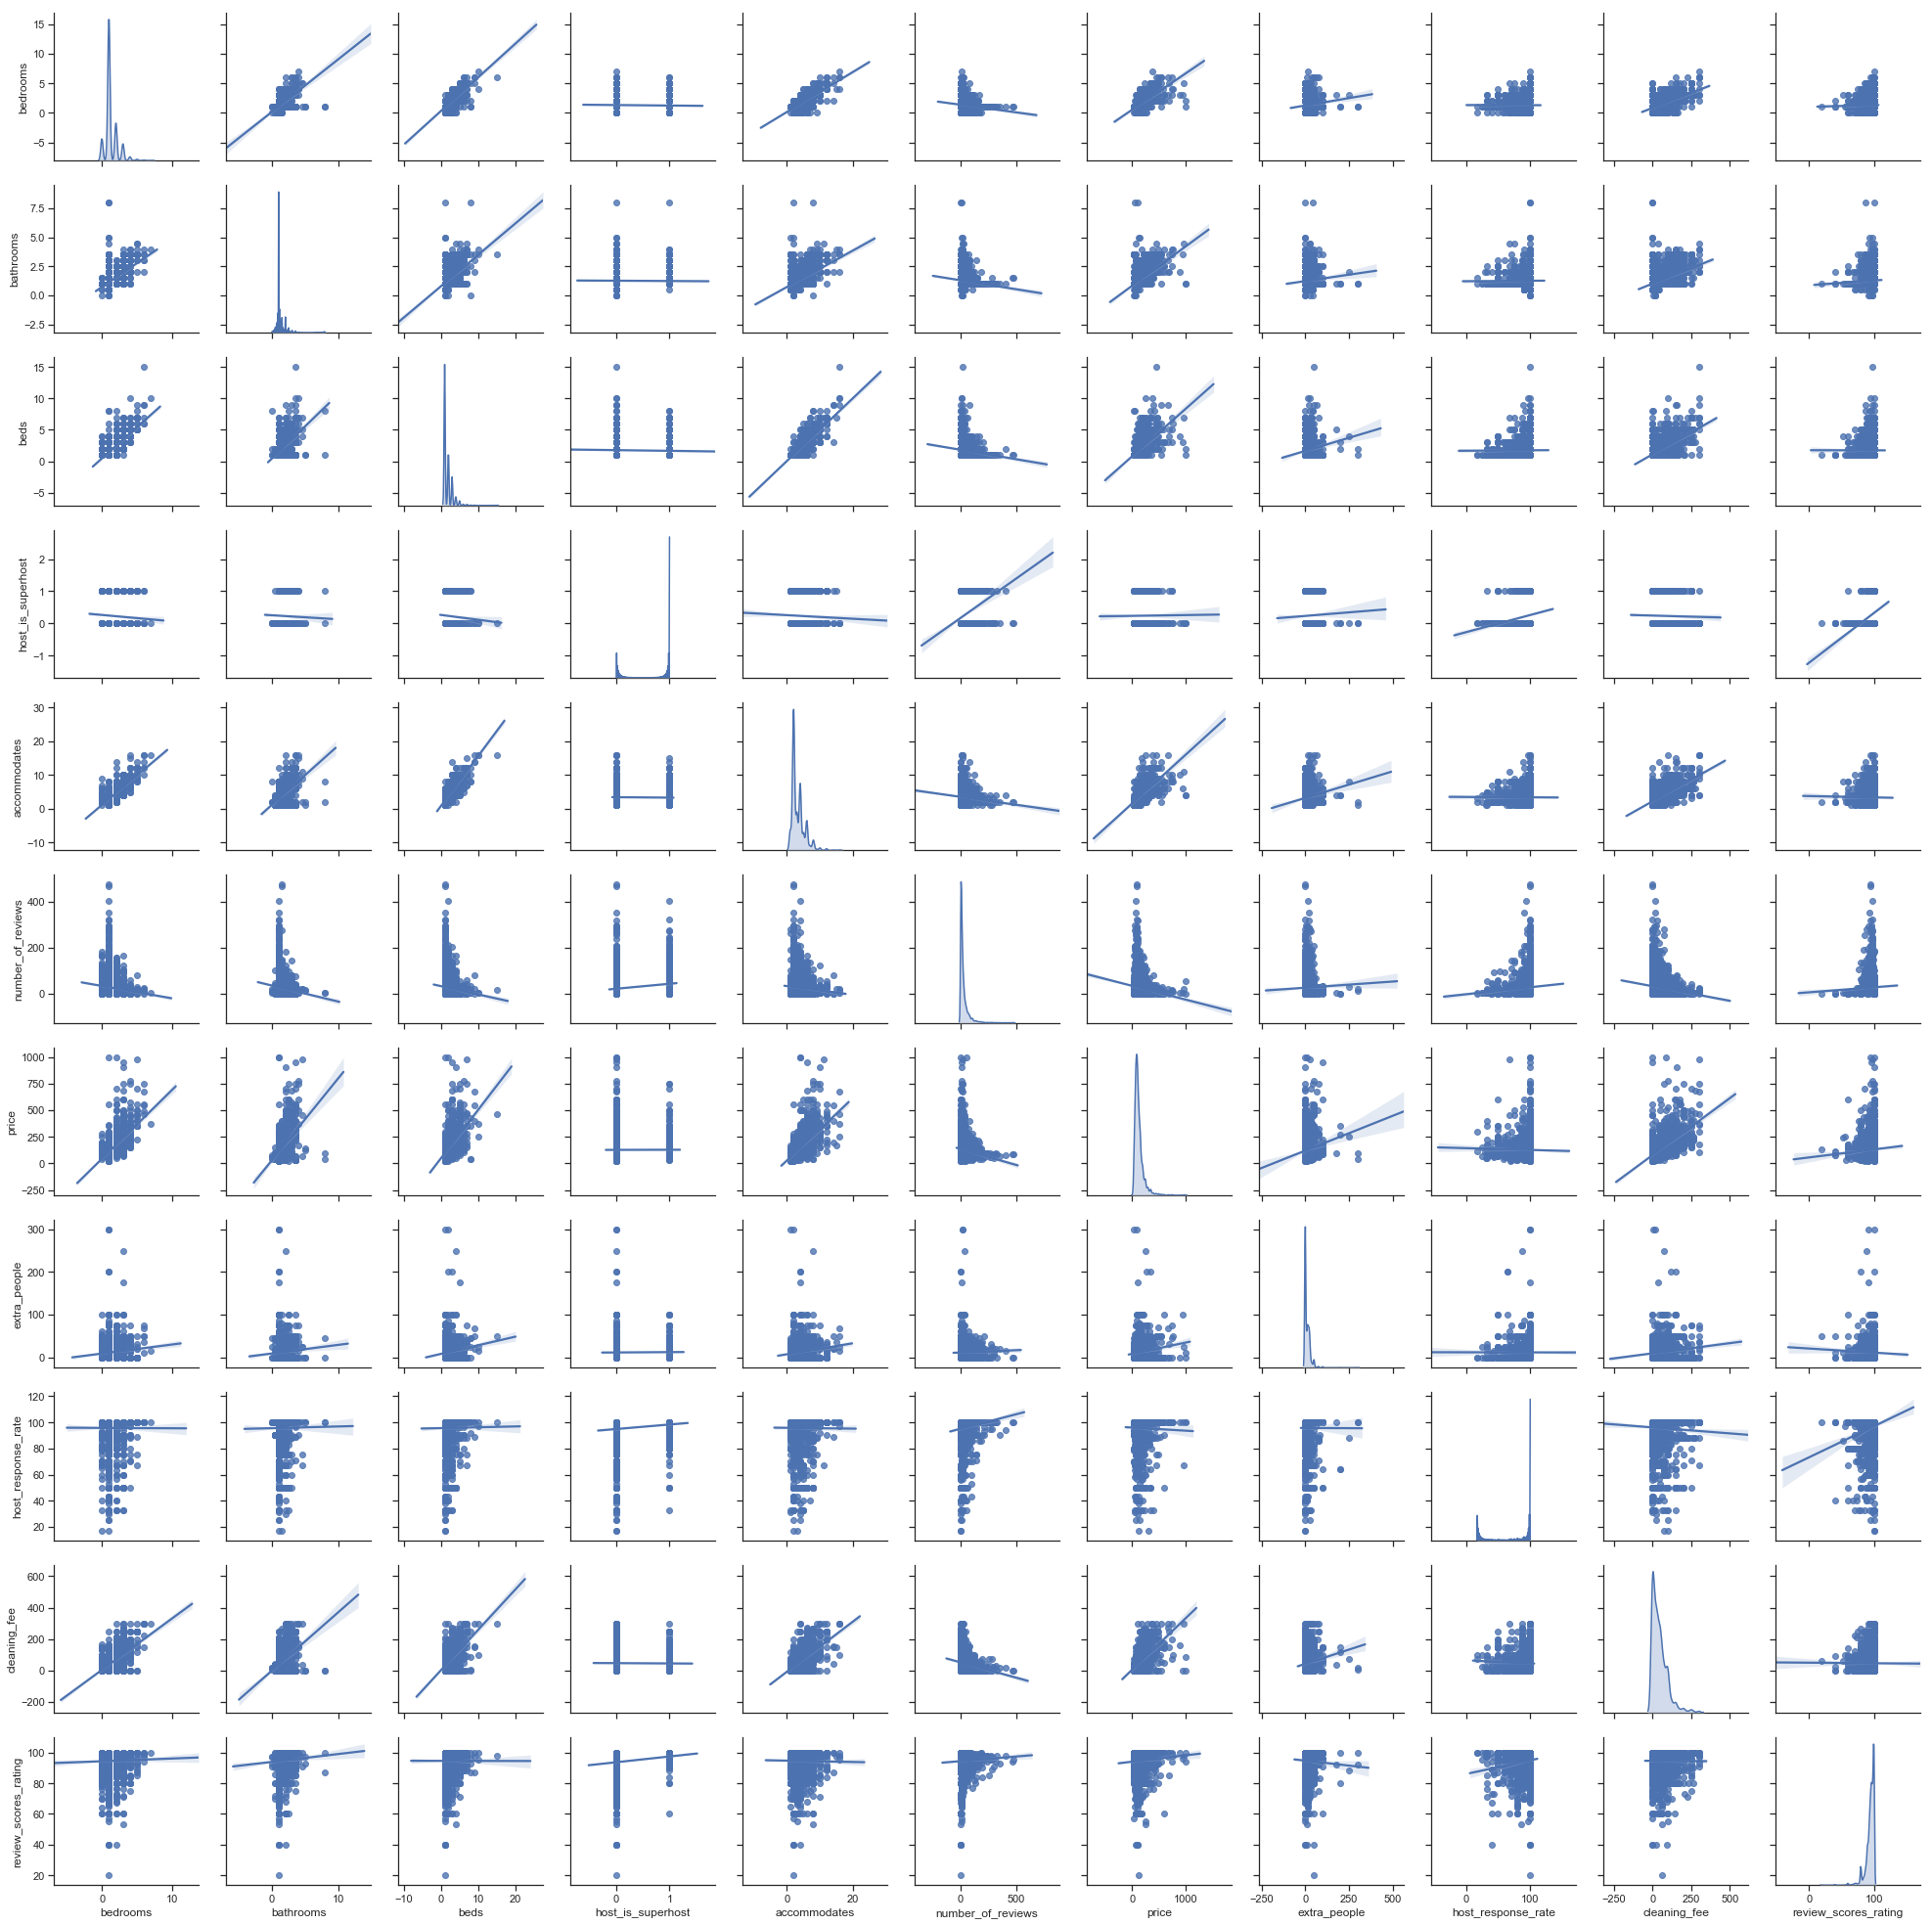

In [37]:
#correlate between continus variable and y
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(subset.drop('zipcode',axis=1),diag_kind='kde',palette="husl", kind='reg')

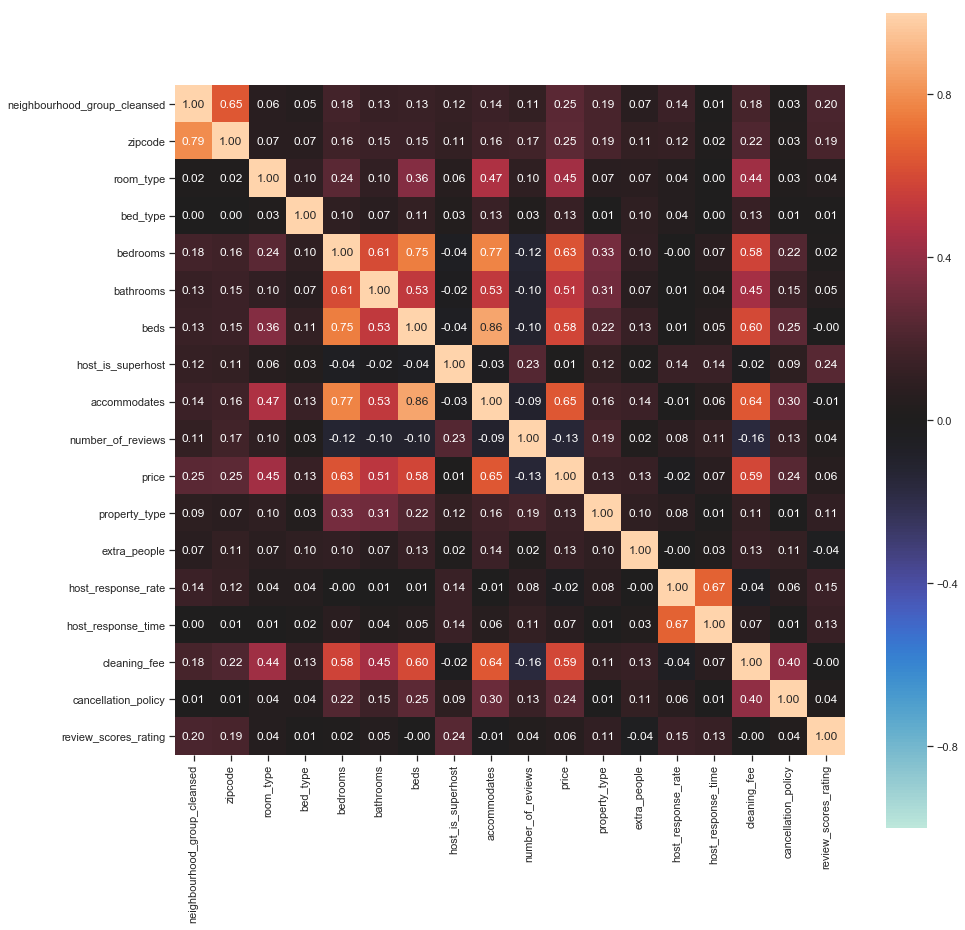

In [38]:
#correlate both categorical and numerical variables with y
fig, ax = plt.subplots(figsize=(15, 15))
associations(subset, theil_u=True, ax=ax)
fig.savefig('Categorical Corr Heat Map.png', bbox_inches='tight')

Conclusion: Besides location (zip code) and property type, the major factor that affects review rating is communication between the host and guest. Host response rate and response time are two key factors that influence whether or not a guest feels accommodated. Working on fast and frequent communication will likely increase the chances of being labelled as “superhost,” which can signifincaly boost review rating.

In [39]:
#Try to build model to predict the review scores
#discard low correlated features (<0.05)
feature = ['zipcode','bathrooms','host_is_superhost','price','property_type','host_response_rate','host_response_time','review_scores_rating']
subset_model = subset[feature]

In [40]:
#create dummy columns for categorical features
for column in ['property_type','host_response_time']:
    dummies = pd.get_dummies(subset_model[column])
    subset_model[dummies.columns] = dummies
subset_model = subset_model.drop(['property_type','host_response_time'], axis=1)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [41]:
#Split train and test data
X = subset_model.drop(['review_scores_rating'], axis=1)
y = subset_model['review_scores_rating']
X_train,X_test, y_train, y_test=train_test_split(X, y,test_size=0.30,random_state=42)

#Fit data into model
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train)

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for your model was 0.09215749687993735 on 952 values.'

Apparently the model need furthur perfection...

# (b) 3. * For “newbies” considering to becoming Airbnb hosts in Seattle, how competitive are they in this market compared to experienced hosts?

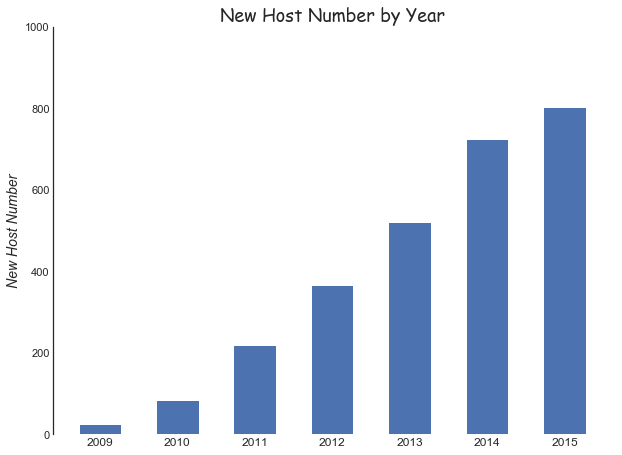

In [42]:
#reload df_listings dataframe
df_listings = pd.read_csv('./listings.csv')

#clean the 'price' column in df_listings
df_listings['price'] = df_listings['price'].str.replace("$","")
df_listings['price']  = df_listings['price'].str.replace("'","")
df_listings['price'] = df_listings['price'].str.replace(",","")
df_listings['price'] = df_listings['price'].astype('float')

#convert host_since column into datetime type
df_listings = df_listings.dropna(subset=['host_since'])
df_listings['host_since'] = pd.to_datetime(df_listings['host_since'])
df_listings['host_year'] = df_listings['host_since'].dt.year
df_listings['host_month'] = df_listings['host_since'].dt.month
df_listings['host_month'] = df_listings['host_month'].apply(lambda x: calendar.month_abbr[x])

#drop year 2008 and 2016 data
indexNames = df_listings[ df_listings['host_year'] == 2008 ].index
df_listings.drop(indexNames , inplace=True)
indexNames = df_listings[ df_listings['host_year'] == 2016 ].index
df_listings.drop(indexNames , inplace=True)

#find out unique host
df_host=df_listings.drop_duplicates(subset=['host_id'])

#evaluate the host_year of each on each unique host_id
hostnumber_year = df_host['host_since'].groupby(df_host['host_year']).count()
hostnumber_year = hostnumber_year.reset_index()
xdata = hostnumber_year['host_year']
ydata = hostnumber_year['host_since']
#plot the graph
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
l = ax.bar(xdata, ydata, width=0.55)
#set the basic properties
ax.set_xlabel('')
ax.set_ylabel('New Host Number')
ax.set_title('New Host Number by Year',fontname="Comic Sans MS")
#set the limits
ax.set_ylim(0, 1000)
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)

plt.savefig('New Host Number by Year.png')

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


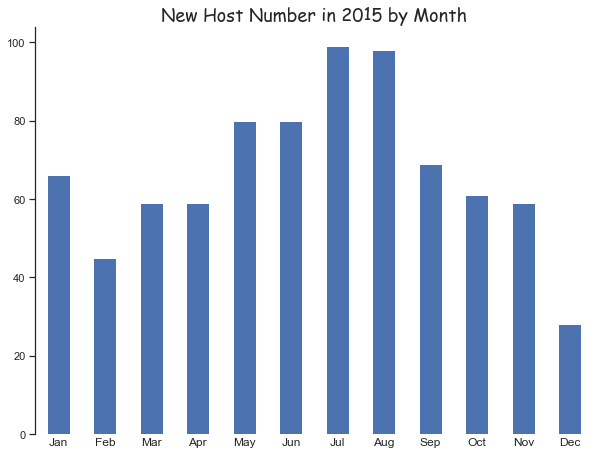

In [43]:
#evaluate the 2015 new host distribution by month
indexNames = df_host[ df_host['host_year'] != 2015].index
df_host.drop(indexNames,inplace=True)
#visualize the distribution of new host in 2015 by month
mons = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
hostnumber_month2015 = df_host['host_since'].groupby(df_host['host_month']).count().reindex(mons)
plt.figure(figsize=(10, 7.5))
#basic setting for the plot
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.set_title("New Host Number in 2015 by Month", fontname="Comic Sans MS")
ax.xaxis.set_tick_params(size=0,labelsize=12)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)
hostnumber_month2015.plot.bar()
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(rotation='horizontal')

plt.savefig('New Host Number in 2015 by Month.png')

<Figure size 1080x504 with 0 Axes>

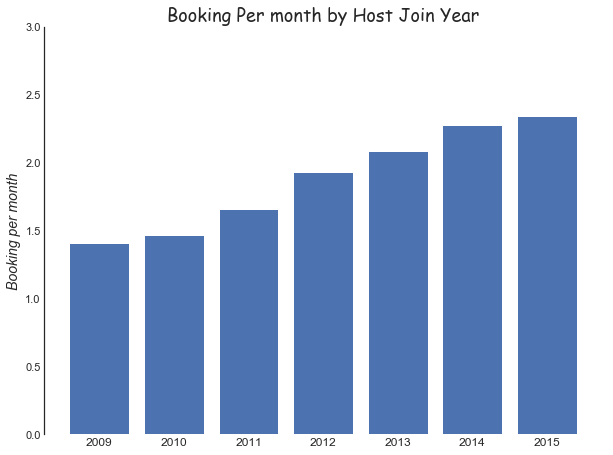

In [44]:
#create bar plot to visualize the average per month book by host join year

#evaluate the relationship between host_since and reviews_per_month
plt.figure(figsize=(15,7))
host_review = df_listings.groupby(['host_year']).mean()[['reviews_per_month']]
host_review = host_review.reset_index()
#create x and y for plotting figure of booking per month by host join year
xdata = host_review['host_year']
ydata = host_review['reviews_per_month']
#plot the graph
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
l = ax.bar(xdata, ydata)
#set the basic properties
ax.set_xlabel('')
ax.set_ylabel('Booking per month')
ax.set_title('Booking Per month by Host Join Year',fontname="Comic Sans MS")
#set the limits
ax.set_ylim(0, 3)
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)

plt.savefig('Booking per month by host join year.png')

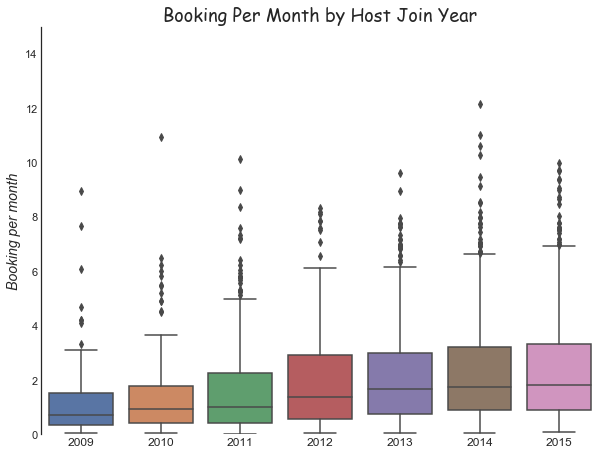

In [45]:
#create box plot to visualize the average per month book by host join year
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
#set the basic properties
ax.set_title('Booking Per Month by Host Join Year',fontname="Comic Sans MS")
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)
ax = sns.boxplot(x="host_year", y="reviews_per_month", data=df_listings)
ax.set(xlabel = '',ylabel = 'Booking per month')
#set the limits
ax.set_ylim(0, 15)

ax.figure.savefig('Booking per month by host join year_box.png', bbox_inches='tight')

<Figure size 1080x504 with 0 Axes>

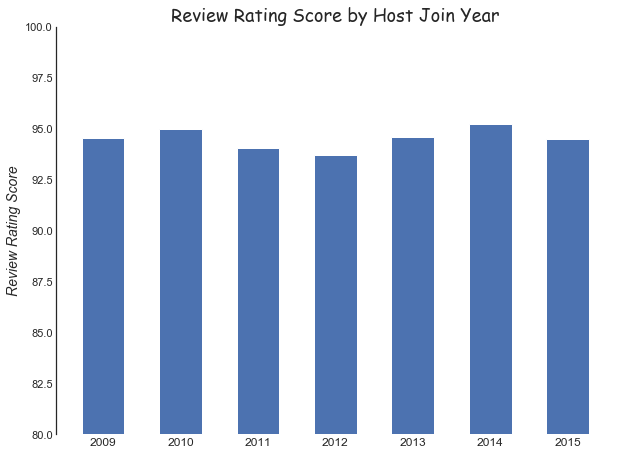

In [46]:
#evaluate the relationship between host_since and average rating scores by bar plot
plt.figure(figsize=(15,7))
host_rating = df_listings.groupby(['host_year']).mean()[['review_scores_rating']]
host_rating = host_rating.reset_index()
#create x and y for plotting figure of booking per month by host join year
xdata = host_rating['host_year']
ydata = host_rating['review_scores_rating']
#plot the graph
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
l = ax.bar(xdata, ydata, width=0.55)
#set the basic properties
ax.set_xlabel('')
ax.set_ylabel('Review Rating Score')
ax.set_title('Review Rating Score by Host Join Year',fontname="Comic Sans MS")
#set the limits
ax.set_ylim(80, 100)
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)

plt.savefig('Review rating score by host join year.png')

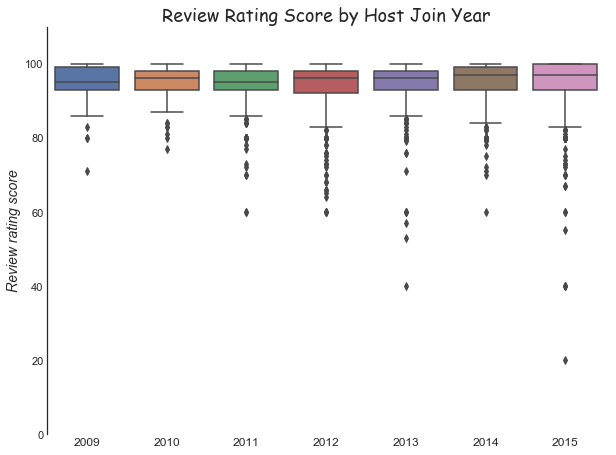

In [47]:
#create box plot to visualize the average rating score by host join year
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
#set the basic properties
ax.set_title('Review Rating Score by Host Join Year',fontname="Comic Sans MS")
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)
ax = sns.boxplot(x="host_year", y="review_scores_rating", data=df_listings)
ax.set(xlabel = '',ylabel = 'Review rating score')
#set the limits
ax.set_ylim(0, 110)

ax.figure.savefig('Review rating score by host join year_box.png',bbox_inches='tight')

In [48]:
#evaluate the relationship between host_since and income in 2015

#convert date to datetime
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

#count each review in 2015 as a book, drop booking except 2015
df_reviews['year']= df_reviews['date'].dt.year
indexNames = df_reviews[ df_reviews['year'] != 2015].index
df_reviews.drop(indexNames,inplace=True)

#count the total booking for each unique listing in 2015
df_booking = df_reviews['listing_id'].value_counts().rename_axis('id').reset_index(name='book')
df_booking.head()

,id,book
0,365550,142
1,208356,141
2,3861673,136
3,794633,129
4,2686374,121


In [49]:
#merge total booking number to listing dataset
df_listings_booking = pd.merge(df_listings, df_booking, on='id')

In [50]:
# total income of 2015 calculated by book# * minimal booking night * price
df_listings_booking['Total income of 2015'] = df_listings_booking["book"] * df_listings_booking["price"] * df_listings_booking['minimum_nights']

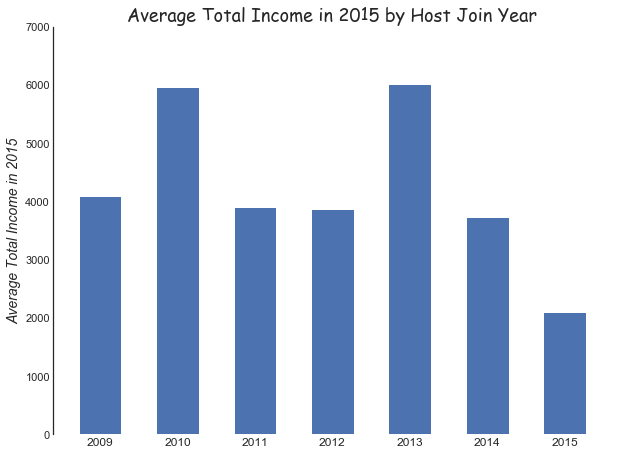

In [51]:
#evaluate the relationship between host_since and total income of 2015 by bar plot
host_2015 = df_listings_booking.groupby(['host_year']).mean()[['Total income of 2015']]
host_2015 = host_2015.reset_index()
#create x and y for plotting figure of booking per month by host join year
xdata = host_2015['host_year']
ydata = host_2015['Total income of 2015']
#plot the graph
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
l = ax.bar(xdata, ydata, width=0.55)
#set the basic properties
ax.set_xlabel('')
ax.set_ylabel('Average Total Income in 2015')
ax.set_title('Average Total Income in 2015 by Host Join Year',fontname="Comic Sans MS")
#set the limits
ax.set_ylim(0, 7000)
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)

plt.savefig('Average total income in 2015.png')

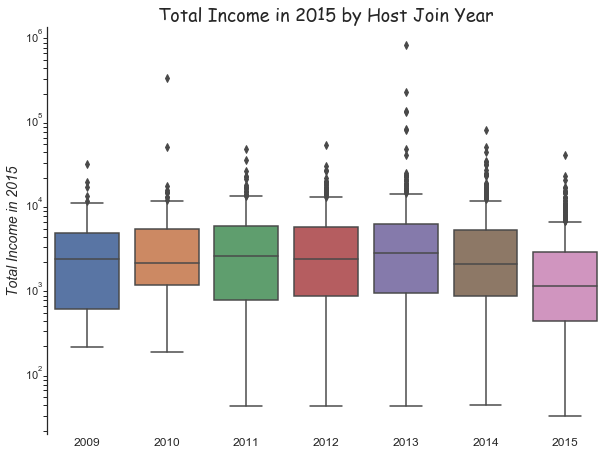

In [55]:
#create box plot to visualize the host 2015 income by host join year
fig = plt.figure(figsize=[10,7.5])
ax = plt.subplot(111)
#set the basic properties
ax.set_title('Total Income in 2015 by Host Join Year',fontname="Comic Sans MS")
#customize the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.xaxis.set_tick_params(size=0,labelsize=12)
ax.yaxis.set_tick_params(size=0)
#customize the text of x and y
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(14)
ylab.set_style('italic')
ylab.set_size(14)
#customize the text of title
ttl = ax.title
ttl.set_size(18)
ax = sns.boxplot(x="host_year", y="Total income of 2015", data=df_listings_booking)
ax.set(xlabel = '',ylabel = 'Total Income in 2015')
#set y as log scale
ax.set_yscale('log')

ax.figure.savefig('Total Income in 2015 by Host Join Year_box.png',bbox_inches='tight')

Conclusion: By looking at the overall income in 2015, the host join Seattle airbnb earn the least money compared with other experienced host. The result is actually expected, because many 2015 new hosts didn't join the market in the beginning of 2015, the total bussiness hour for who join airbnb for 2015 host was much shorter than others. But by looking at more time-independent parameters, such as the average review rating score and average booking per month, the young hosts actually exhibit very strong competitivity. Another point to note is the dramatic increase in number of new hosts since 2013. If you are about to jumping into this market, the biggest challenge will not be competition with experienced hosts, but with your “newbie” peers.